In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from torchvision import models
import pandas as pd
import cv2
import os
import matplotlib.pyplot as plt
from torchvision import transforms

In [ ]:
# Определяем класс кастомного датасета
class CustomDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform  # Принимаем аугментацию как параметр

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Загружаем и обрабатываем изображение
        image = preprocess_image(self.image_paths[idx])
        label = self.labels[idx]

        # Применяем аугментацию, если она задана
        if self.transform:
            image = self.transform(image)

        return image, label

In [ ]:
# Функция предобработки изображения
def preprocess_image(image_path):
    image = cv2.imread(image_path)  # OpenCV может читать JPG, JPEG и PNG
    if image is None:
        raise ValueError(f"Unable to read the image at {image_path}")  # Проверка, была ли загружена картинка
    image = cv2.resize(image, (128, 128))  # Изменение размера
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Преобразование цвета
    image = image / 255.0  # Нормализация значений пикселей
    return image

In [ ]:
# Определяем аугментации
data_transforms = transforms.Compose([
    transforms.ToPILImage(),                 # Преобразование в PIL перед применением аугментации
    transforms.RandomHorizontalFlip(),        # Случайное горизонтальное отражение
    transforms.RandomRotation(10),            # Случайное вращение на 10 градусов
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Изменение яркости, контрастности и насыщенности
    transforms.ToTensor(),                    # Преобразование изображения в тензор
])

In [ ]:
# Функция для загрузки новых данных в CSV
def load_new_data(image_paths, labels, csv_file='dataset.csv'):
    try:
        existing_data = pd.read_csv(csv_file)
    except FileNotFoundError:
        existing_data = pd.DataFrame(columns=['image_path', 'label'])

    new_data = pd.DataFrame({'image_path': image_paths, 'label': labels})
    combined_data = pd.concat([existing_data, new_data]).drop_duplicates().reset_index(drop=True)
    combined_data.to_csv(csv_file, index=False)

In [ ]:
# Функция для загрузки датасета из CSV
def load_dataset_from_csv(csv_file):
    data = pd.read_csv(csv_file)
    image_paths = data['image_path'].tolist()
    # Преобразуем метки в числа: logo1 = 0, logo2 = 1, no_logo = 2
    labels = data['label'].apply(lambda x: 0 if x == 'logo1' else (1 if x == 'logo2' else 2)).tolist()
    return image_paths, labels

In [ ]:
# Определение модели логотипа с 3 классами
class LogoClassifier(nn.Module):
    def __init__(self):
        super(LogoClassifier, self).__init__()
        self.base_model = models.resnet18(pretrained=True)  # Предобученная ResNet
        self.base_model.fc = nn.Linear(self.base_model.fc.in_features, 3)  # Выход для 3 классов

    def forward(self, x):
        return self.base_model(x)

In [ ]:
# Основной код
device = 'cuda' if torch.cuda.is_available() else 'cpu'  # Определяем устройство (GPU или CPU)
model = LogoClassifier().to(device)  # Инициализируем модель и помещаем на устройство

criterion = nn.CrossEntropyLoss()  # Функция потерь для многоклассовой классификации
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Оптимизатор Adam

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 67.0MB/s]


In [ ]:
# Загрузка данных из CSV
image_paths, labels = load_dataset_from_csv('/content/sample_data/logo1.csv')  # Загружаем данные
dataset = CustomDataset(image_paths, labels, transform=data_transforms)  # Создаем кастомный датасет с аугментацией
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)  # Создаем загрузчик данных

In [ ]:
# Обучение модели
num_epochs = 15  # Количество эпох обучения
model.train()  # Установка модели в режим обучения
for epoch in range(num_epochs):
    for images, labels in dataloader:
        optimizer.zero_grad()  # Обнуляем градиенты
        images = images.float().to(device)  # Преобразуем в тензор и отправляем на устройство
        labels = torch.tensor(labels).to(device)  # Преобразуем метки в тензор и отправляем на устройство

        outputs = model(images)  # Пропускаем изображения через модель
        loss = criterion(outputs, labels)  # Вычисляем функцию потерь
        loss.backward()  # Обратное распространение
        optimizer.step()  # Шаг оптимизатора

    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')  # Печатаем потерю

<ipython-input-15-5abc17636409>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)  # Преобразуем метки в тензор и отправляем на устройство


Epoch [1/15], Loss: 0.4552
Epoch [2/15], Loss: 0.8685
Epoch [3/15], Loss: 0.0356
Epoch [4/15], Loss: 0.0519
Epoch [5/15], Loss: 0.0569
Epoch [6/15], Loss: 0.0468
Epoch [7/15], Loss: 0.0240
Epoch [8/15], Loss: 0.0495
Epoch [9/15], Loss: 0.1312
Epoch [10/15], Loss: 0.0137
Epoch [11/15], Loss: 0.0182
Epoch [12/15], Loss: 0.0948
Epoch [13/15], Loss: 0.0697
Epoch [14/15], Loss: 0.0026
Epoch [15/15], Loss: 0.0379


In [ ]:
# Сохранение финальной модели
torch.save(model.state_dict(), 'logo_classifier.pth')  # Сохранение параметров модели

In [ ]:
# Загрузка обученной модели
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = LogoClassifier().to(device)
model.load_state_dict(torch.load('logo_classifier.pth'))
model.eval()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
<ipython-input-17-1f29c97c1f47>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more detail

LogoClassifier(
  (base_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True,

In [ ]:
# Функция для предобработки тестового изображения
def preprocess_test_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.resize(image, (128, 128))  # Изменение размера
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Преобразование цвета
    image = image / 255.0  # Нормализация
    image_tensor = transforms.ToTensor()(image).unsqueeze(0).to(device).float()  # Преобразование в тензор и установка типа Float
    return image_tensor

In [ ]:
# Функция для предсказания класса для нескольких изображений
def predict_multiple(image_paths):
    predictions = []
    for image_path in image_paths:
        image_tensor = preprocess_test_image(image_path)  # Предобработка
        with torch.no_grad():  # Отключаем вычисление градиентов
            output = model(image_tensor)  # Получаем предсказание
        _, predicted_idx = torch.max(output, 1)  # Получаем индекс класса с максимальным значением
        predictions.append(predicted_idx.item())  # Сохраняем предсказание
    return predictions

In [ ]:
# Функция для получения всех изображений из папки
def get_image_paths_from_folder(folder_path):
    image_paths = []
    for filename in os.listdir(folder_path):
        if filename.endswith(('.jpg', '.jpeg', '.png')):  # Фильтруем только изображения
            image_paths.append(os.path.join(folder_path, filename))  # Получаем полный путь
    return image_paths

In [ ]:
# Функция для отображения результатов предсказания
def display_multiple_results(image_paths):
    predictions = predict_multiple(image_paths)  # Получаем предсказания
    class_labels = ['vk', 'yandex', 'no_logo']  # Метки классов

    for image_path, predicted_idx in zip(image_paths, predictions):
        predicted_class = class_labels[predicted_idx]  # Преобразуем индекс в метку

        # Отображение изображения и предсказанного класса
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Преобразование цвета для отображения
        plt.imshow(image)  # Показываем изображение
        plt.title(f'Predicted: {predicted_class}')  # Заголовок с результатом
        plt.axis('off')  # Отключаем оси
        plt.show()  # Отображаем график

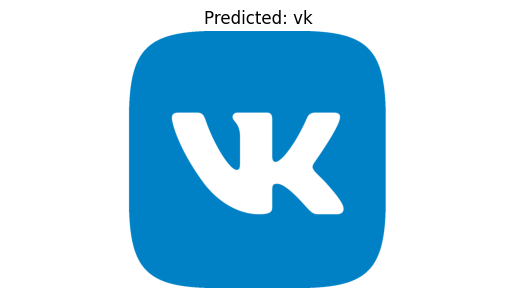

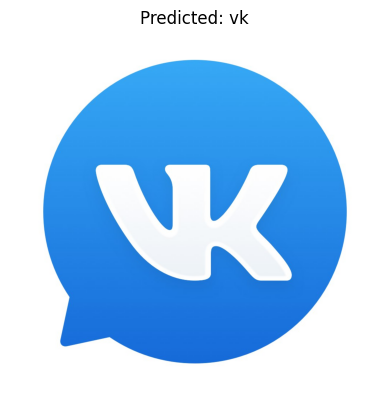

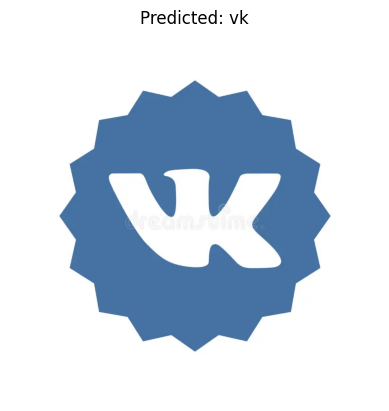

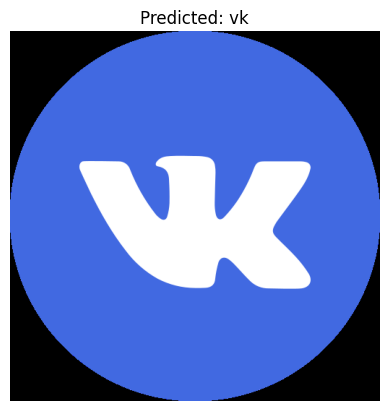

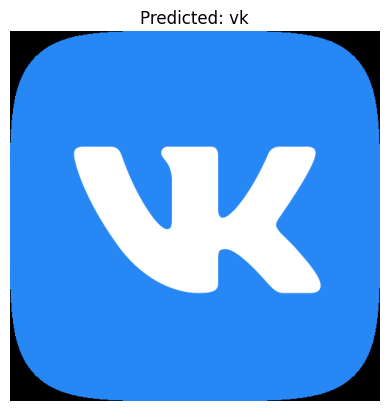

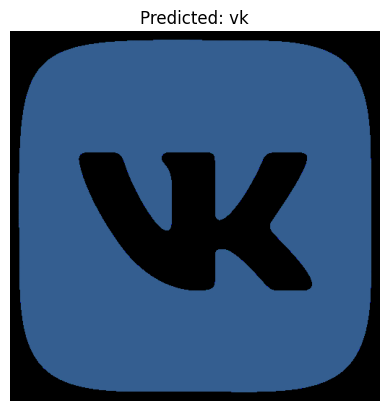

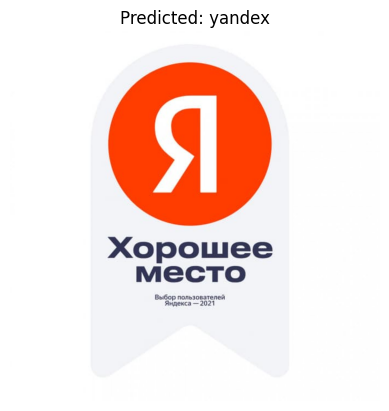

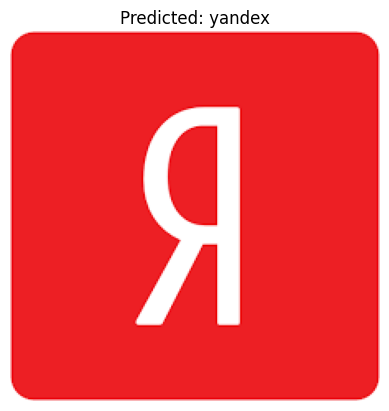

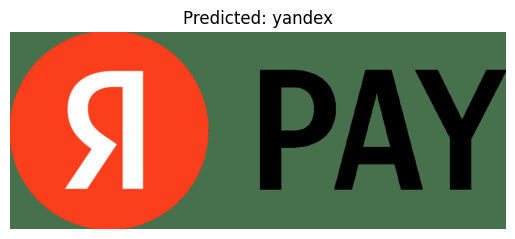

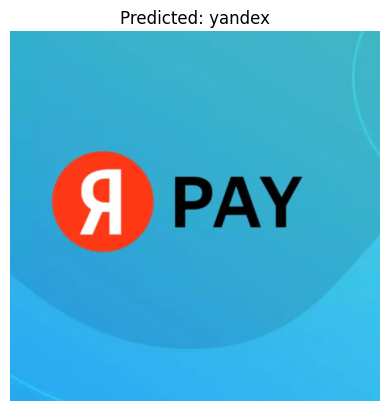

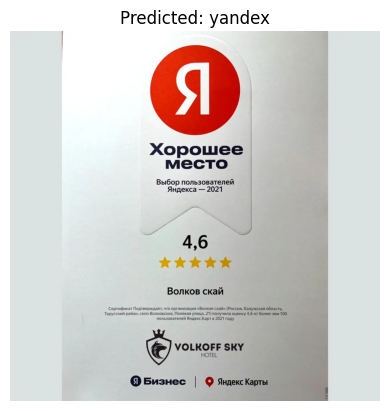

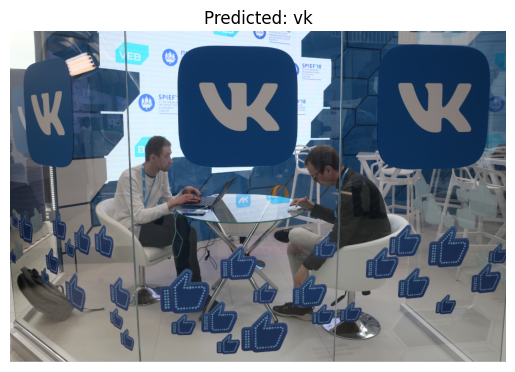

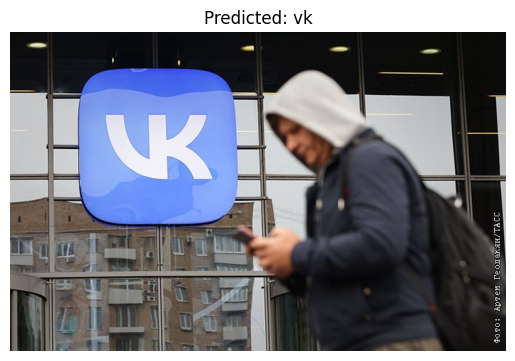

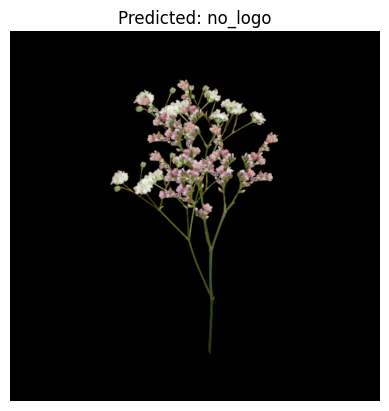

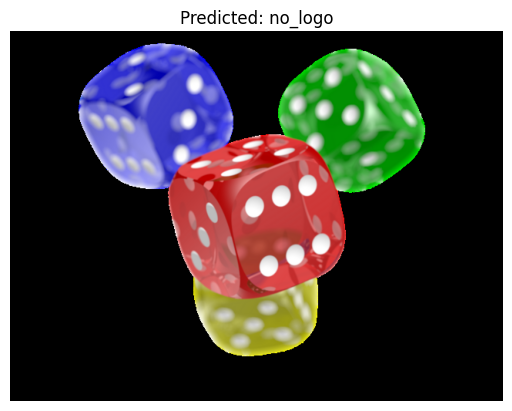

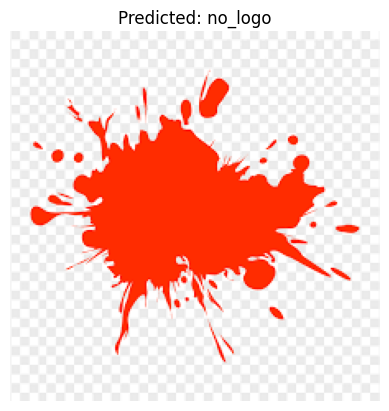

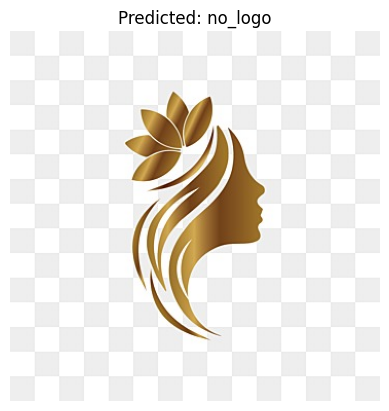

In [ ]:
# указываем путь к папке с изображениями
folder_path = '/content/drive/MyDrive/test_logo'  # Укажите путь к вашей папке
test_image_paths = get_image_paths_from_folder(folder_path)  # Получаем пути к изображениям из папки

# Тестируем и отображаем результаты
display_multiple_results(test_image_paths)

Модель продемонстрировала отличные результаты в классификации логотипов, показав 100% точность на тестовых изображениях, что свидетельствует о ее высокой обобщающей способности и способности корректно идентифицировать три класса: vk, yandex, no_logo.

Небольшие колебания потерь (например, увеличение на 9-й эпохе) могло быть вызвано несколькими факторами:
небольшим переобучением на некоторых подмножествах обучающей выборки и
аугментацией данных, которая иногда может приводить к усложнению задач.

Тем не менее, в целом потери демонстрируют устойчивый тренд к снижению, что подтверждает прогресс в обучении.
